# 1

In [46]:
from astropy.nddata import CCDData

image = CCDData.read('NGC7331.fits.bz2')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
image.unit

Unit("nmgy")

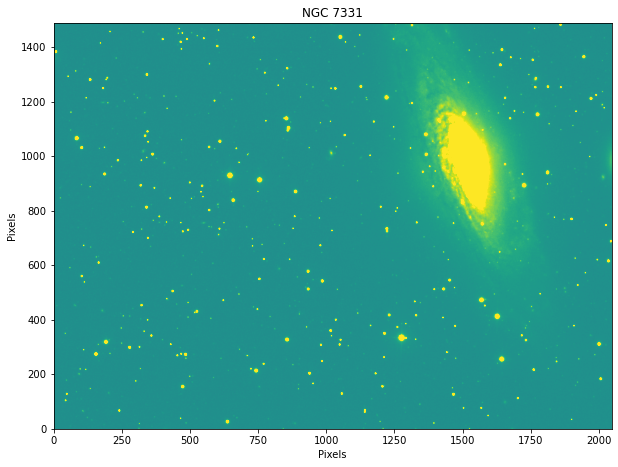

In [47]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax = image.data.std() # Use the image std as max and min of all plots
vmin = - vmax

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("NGC 7331")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

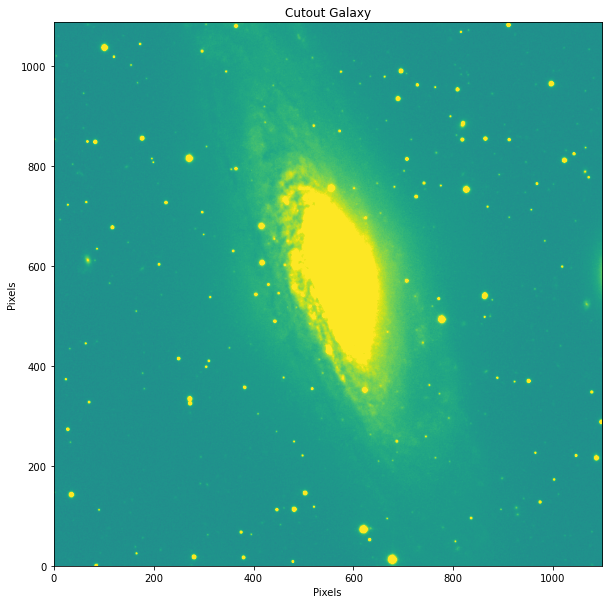

In [48]:
from astropy.nddata import Cutout2D

cutout_image = Cutout2D(image, position=(1550,1000), size=1200)


plt.imshow(cutout_image.data, vmin=vmin, vmax=vmax)
plt.title("Cutout Galaxy")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

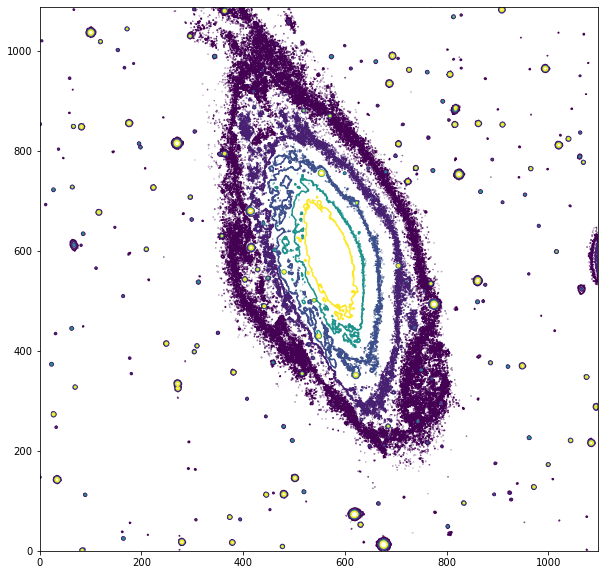

In [49]:
ax = plt.subplot()
# ax.imshow(cutout_image.data, vmin=vmin, vmax=vmax) #original image
ax.contour(cutout_image.data, levels=np.logspace(-0.5, 0.5, 5))#, colors='white', alpha=0.5)

# 2

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


-0.0014192562 0.15751595422625542 0.4200425446033478


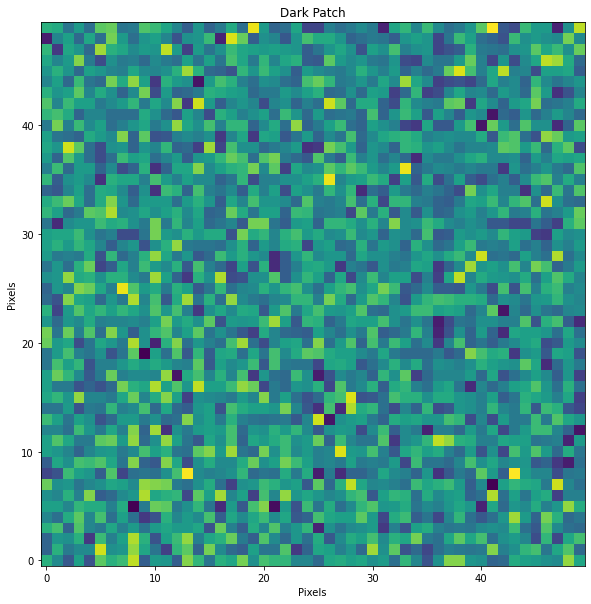

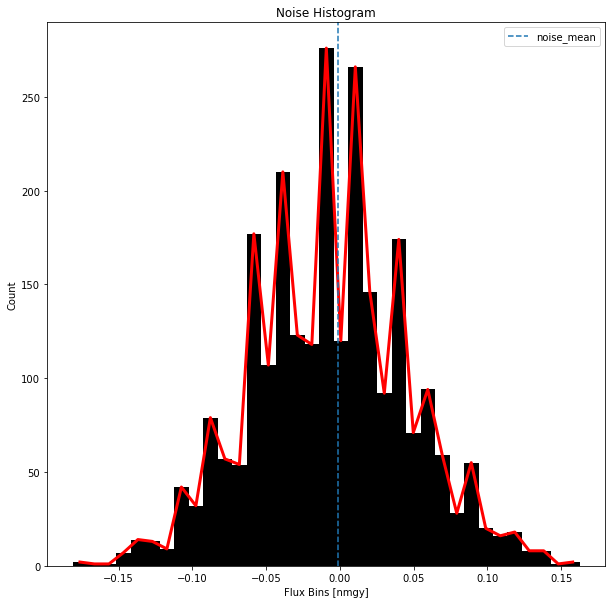

In [100]:
from astropy.nddata import Cutout2D
from astropy.nddata import CCDData

image = CCDData.read('kecil.fits.bz2')

# Estimate data noise at dark area
# --------------------------------
noise_cutout_pos = (50, 50)
noise_cutout_size = 50
noise_cutout = Cutout2D(image, noise_cutout_pos, noise_cutout_size)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_1_sigma = noise_sigma * 1.
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

# Plot image and noise distribution
# ---------------------------------
plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.title("Dark Patch")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)
plt.axvline(noise_mean, label="noise_mean", linestyle="--")

plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.legend()

plt.show()

In [102]:
from astropy.stats import sigma_clipped_stats
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

In [142]:
# Define detect threshold
threshold = noise_3_sigma

In [164]:
kernel_size = 7
fwhm = 3
#sigma = fwhm * gaussian_fwhm_to_sigma
#kernel = Gaussian2DKernel(sigma, x_size=kernel_size, y_size=kernel_size)

In [202]:
npixels = int(np.floor(12.2**2))

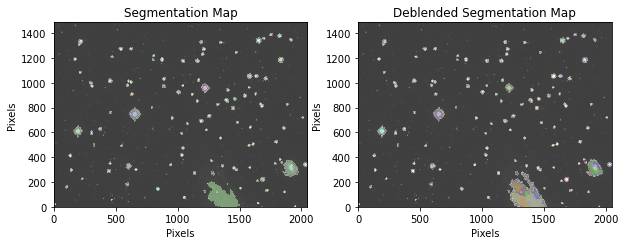

In [203]:
from petrofit.segmentation import make_catalog, plot_segments

cat, segm, segm_deblend = make_catalog(
    image.data,
    threshold,
    deblend=True,
    kernel_size=kernel_size,
    fwhm=fwhm,
    npixels=npixels,
    plot=True, vmax=vmax, vmin=vmin
)

In [204]:
# Display source properties
print("Num of Targets:", len(cat))

# Convert to table
cat_table = cat.to_table()

cat_table[:10]

Num of Targets: 123


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1944.1863309409198,4.2844156969644445,None,1935,1954,0,14,230.0,2.0723519558656647,1.9275922881785839,-9.420885756453641,0.36718695378465865,0.0850830078125,63.6875,0.0,929.65576171875,nan,892.2609063270547,nan
2,6.506735703496823,22.47337985170722,None,0,15,14,31,213.0,2.0977993404275423,1.9485681677784747,-89.50782192143556,0.3704234682095083,-0.0858154296875,31.75,0.0,500.6018981933594,nan,485.14481600922727,nan
3,1643.7717791546925,29.55044337988407,None,1635,1657,21,38,272.0,2.5966308724130522,2.0648643853887054,-28.471141755896458,0.60633535021029,0.084716796875,37.8125,0.0,573.183837890625,nan,550.5267787909986,nan
4,464.4286458123017,58.605967775147874,None,458,471,52,65,149.0,1.8950993084624066,1.8486094390475953,-42.49635074724218,0.22013962235342452,0.06134033203125,15.71875,0.0,243.35003662109375,nan,239.99493724615263,nan
5,1050.637971749641,76.34152295828157,None,1039,1062,65,88,417.0,2.300292228948494,2.233580762092567,-71.35744371099942,0.2390847677054633,0.068115234375,130.25,0.0,2044.94775390625,nan,1932.3910118930216,nan
6,1216.4268271199373,125.11250106109827,None,1203,1227,113,136,351.0,6.379456180187544,5.110674941114964,-56.90830725760683,0.5985110980752951,0.06134033203125,0.3427734375,0.0,66.86785888671875,nan,894.3715676704069,nan
7,1858.6372252368442,121.9689954547414,None,1851,1866,114,129,186.0,1.9839269805975273,1.9504991959952762,-64.54882682556371,0.18279689489829465,0.041748046875,28.3125,0.0,413.430908203125,nan,402.89002655975264,nan
8,1718.5240518705523,134.04898600985945,None,1701,1729,126,143,343.0,4.92090145444391,2.062865180027211,8.924548785951123,0.9078917291626227,0.04852294921875,40.5,0.0,719.884765625,nan,710.7574864886574,nan


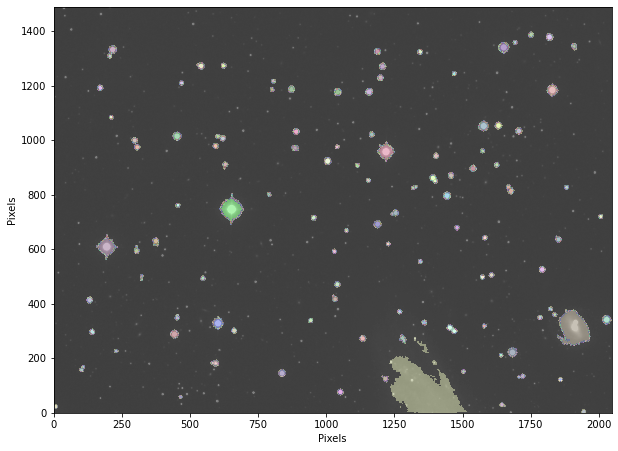

In [205]:
from petrofit.segmentation import plot_segments

plot_segments(segm, image=image.data, vmax=vmax, vmin=vmin)

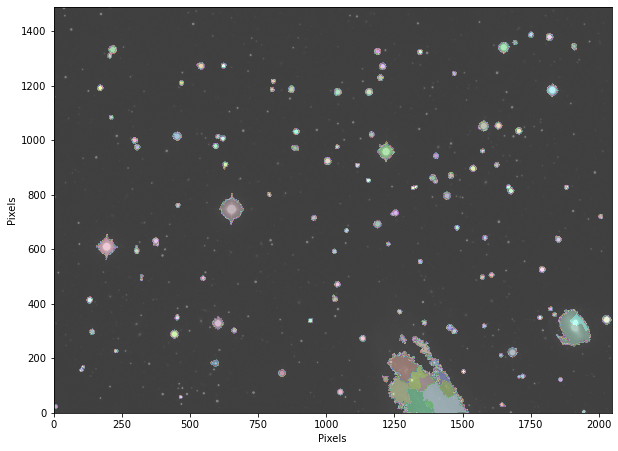

In [206]:
plot_segments(segm_deblend, image=image.data, vmax=vmax, vmin=vmin)

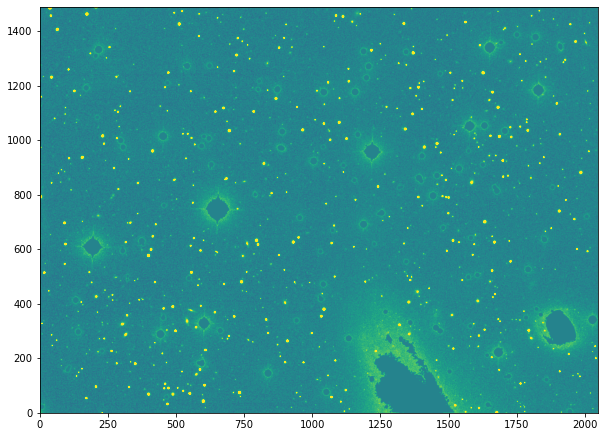

In [207]:
from petrofit.segmentation import plot_segment_residual
plot_segment_residual(segm, image.data, vmax=vmax/5)

In [213]:
from petrofit.photometry import order_cat

# Sort and get the largest object in the catalog
sorted_idx_list = order_cat(cat, key='area', reverse=True)
idx = sorted_idx_list[1] # index 0 is largest
source = cat[idx]  # get souce from the catalog

In [211]:
from petrofit.photometry import make_radius_list

r_list = make_radius_list(
    max_pix=200, # Max pixel to go up to
    n=50 # the number of radii to produce
)

print(repr(r_list))

array([  4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.,
        48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,  88.,
        92.,  96., 100., 104., 108., 112., 116., 120., 124., 128., 132.,
       136., 140., 144., 148., 152., 156., 160., 164., 168., 172., 176.,
       180., 184., 188., 192., 196., 200.])


120


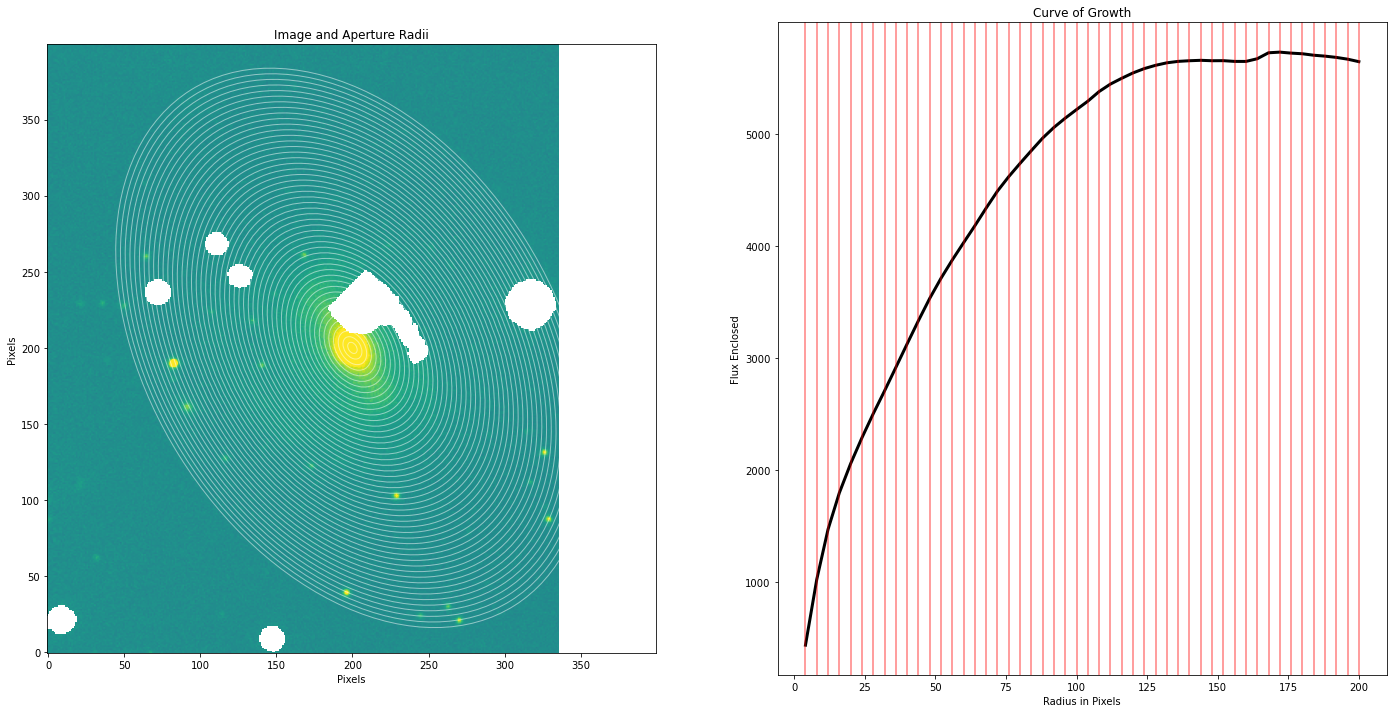

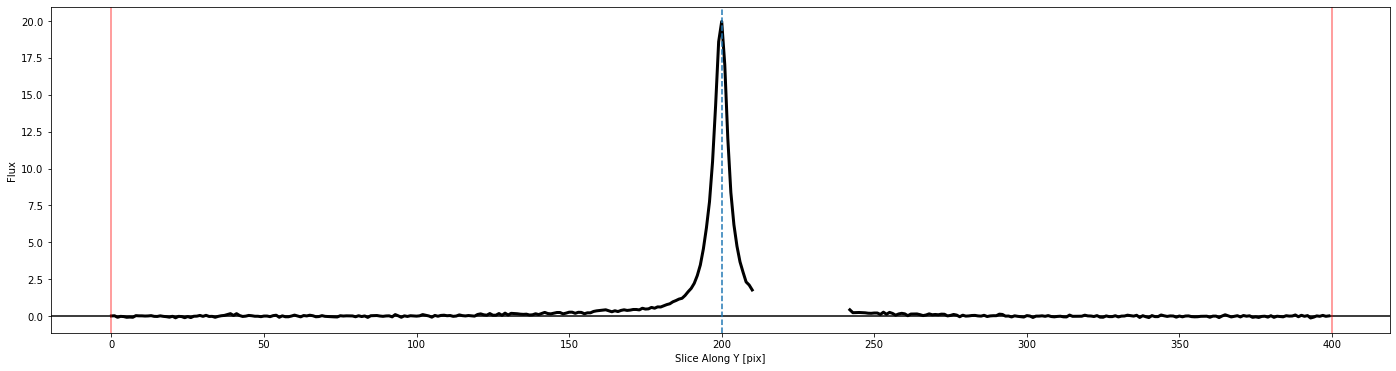

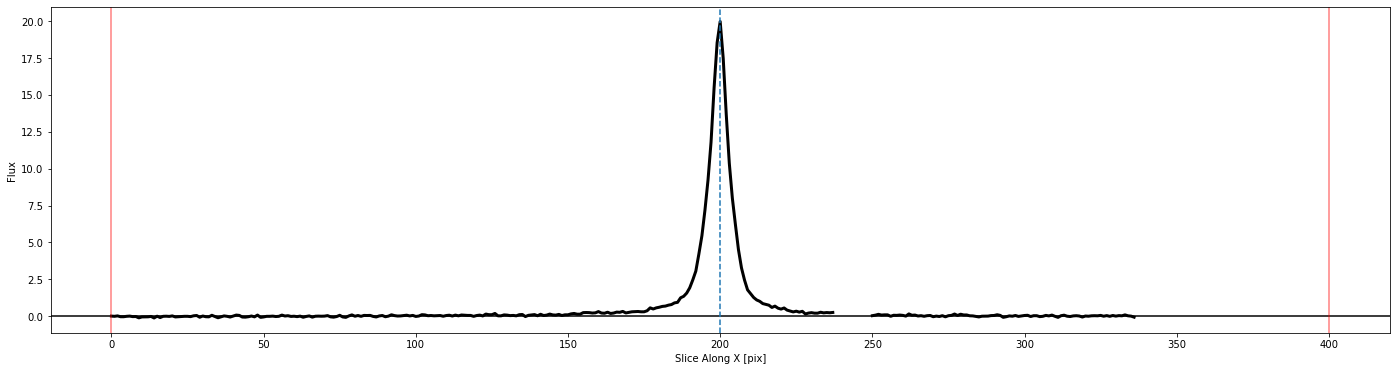

In [214]:
from petrofit.photometry import source_photometry

# Photomerty
flux_arr, area_arr, error_arr = source_photometry(

    # Inputs
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii

    # Options
    cutout_size=2*max(r_list), # Cutout out size, set to double the max radius
    bkg_sub=True, # Subtract background
    sigma=3, sigma_type='clip', # Fit a 2D plane to pixels within 3 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)
plt.show()

In [215]:
from astropy.table import Table

t = Table(
    data=[r_list, flux_arr, area_arr, error_arr],
    names=['r_list', 'flux_arr', 'area_arr', 'error_arr'],
)

t.write('sampel_galaxy.csv', overwrite=True)

t[:10]

r_list,flux_arr,area_arr,error_arr
float64,float64,float64,float64
4.0,434.524422,33.694137,nan
8.0,1021.657374,134.77655,nan
12.0,1469.39421,303.057657,nan
16.0,1795.112551,513.767256,nan
20.0,2055.758715,760.020153,nan
24.0,2286.834224,1051.119932,nan
28.0,2501.527299,1390.158983,nan
32.0,2705.231307,1783.935919,nan
36.0,2914.569278,2254.436514,nan


In [216]:
from petrofit.petrosian import Petrosian

p = Petrosian(r_list, area_arr, flux_arr)

In [217]:
p.r_petrosian # in pixels

92.8985797159432

In [218]:
p.total_flux 

5699.588247944747

In [219]:
mag = 22.5 - 2.5*np.log10(p.total_flux)
mag

13.110391294197985

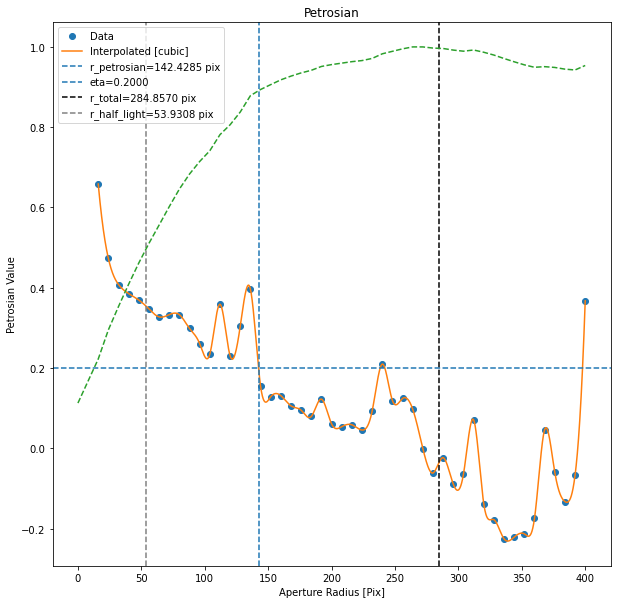

In [52]:
p.plot(plot_r=True, plot_normalized_flux=True)
plt.show()

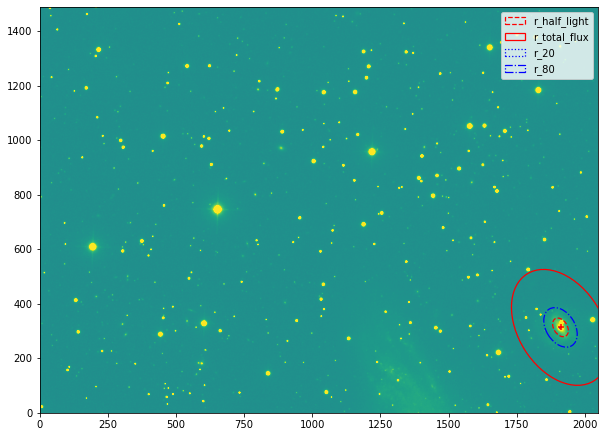

In [27]:
from petrofit.segmentation import get_source_position, get_source_elong, get_source_theta

position = get_source_position(source)
elong = get_source_elong(source)
theta = get_source_theta(source)

p.imshow(position=position, elong=elong, theta=theta, lw=1.25)

plt.imshow(image.data, vmax=vmax, vmin=vmin)

plt.legend()
plt.show()